c:\Users\gokalp\.conda\envs\myworksv2\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Saved:
 - C:\Users\gokalp\Desktop\PTC\statisticsforfeatures\feature_tests_all_vars.csv
 - C:\Users\gokalp\Desktop\PTC\statisticsforfeatures\feature_tests_all_vars.xlsx


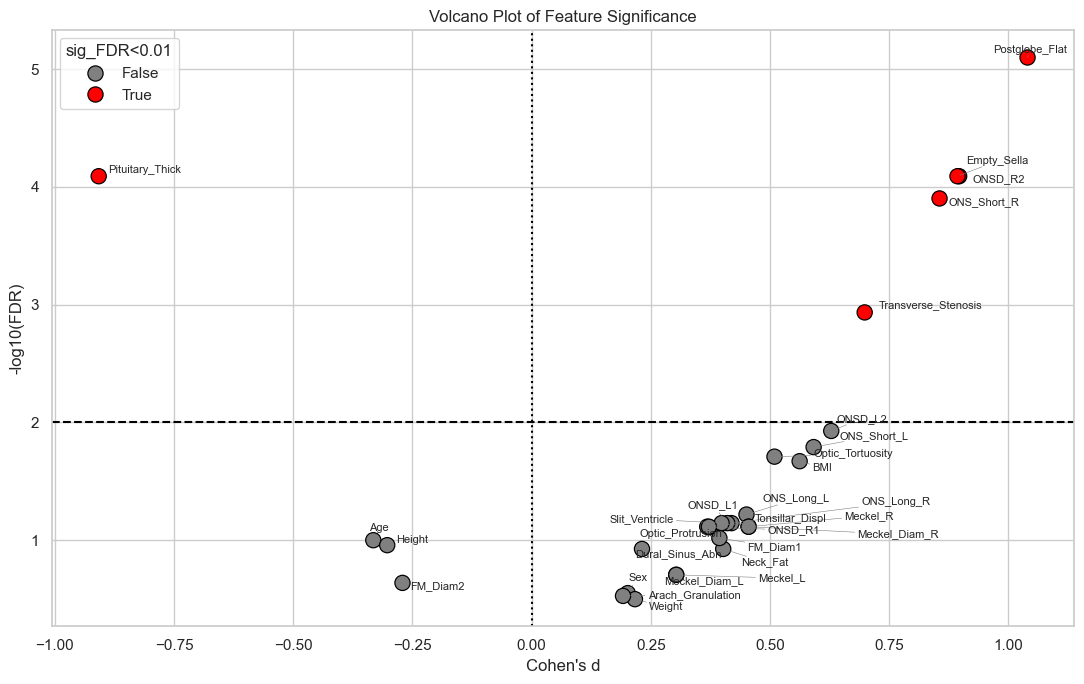

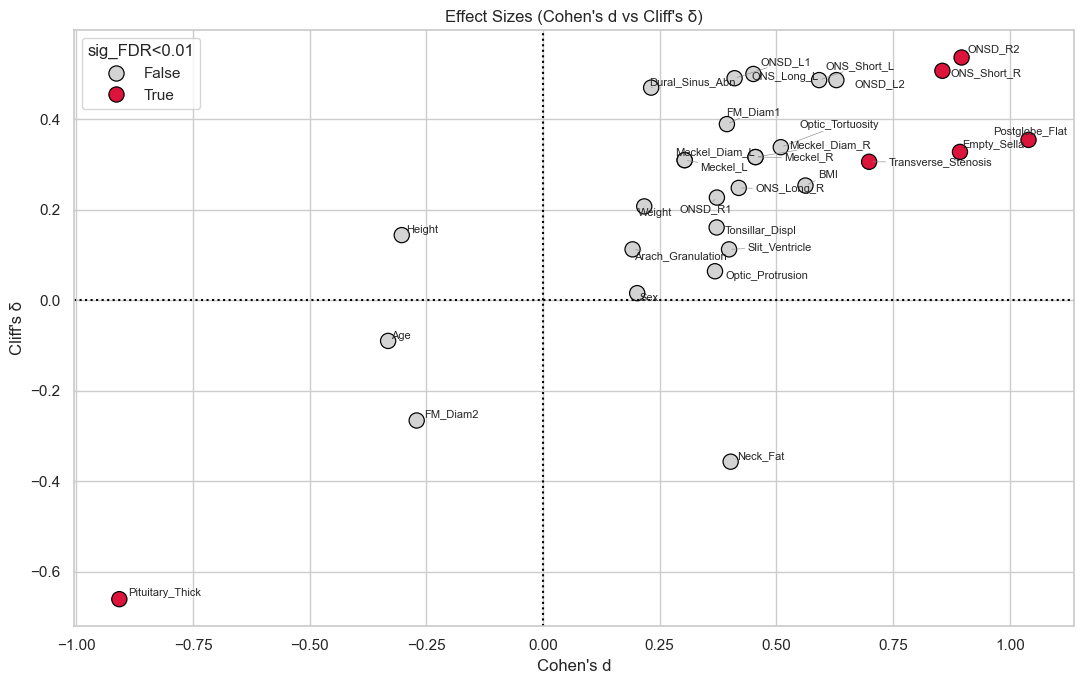


✓ Figures saved successfully with NON-EMPTY content.


In [1]:
# ===============================================
# BLOCK 1 — LOAD DATA & SETUP
# ===============================================
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats as st
from statsmodels.stats.multitest import multipletests

# Input / Output paths
INPUT_PATH = r"C:\Users\gokalp\Desktop\PTC\PTC.xlsx"
OUT_DIR = Path(r"C:\Users\gokalp\Desktop\PTC\statisticsforfeatures")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV  = OUT_DIR / "feature_tests_all_vars.csv"
OUT_XLSX = OUT_DIR / "feature_tests_all_vars.xlsx"

# Load data
df = pd.read_excel(INPUT_PATH)
df.columns = [c.strip() for c in df.columns]

# Ensures Group column exists
if "Group" not in df.columns:
    raise ValueError("Dataset must contain a 'Group' column with values 0/1.")

# Drop NA in group and ensure binary
df = df.dropna(subset=["Group"])
classes = sorted(df["Group"].unique())
if len(classes) != 2:
    raise ValueError(f"Group must be binary (0/1). Found: {classes}")

class0, class1 = classes
df["Group"] = df["Group"].astype(int)

# Split by group
df0 = df[df["Group"] == class0]
df1 = df[df["Group"] == class1]

# ===============================================
# BLOCK 2 — HELPER FUNCTIONS
# ===============================================

def cohen_d_welch(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    if a.size < 2 or b.size < 2:
        return np.nan
    s1 = np.std(a, ddof=1); s0 = np.std(b, ddof=1)
    sp = np.sqrt((s1**2 + s0**2) / 2)
    if sp == 0 or np.isnan(sp): return np.nan
    return (a.mean() - b.mean()) / sp

def cliffs_delta(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[~np.isnan(a)]; b = b[~np.isnan(b)]
    if len(a) == 0 or len(b) == 0: return np.nan
    total = 0
    for x in np.sort(a):
        lt = np.searchsorted(b, x, "left")
        gt = len(b) - np.searchsorted(b, x, "right")
        total += (lt - gt)
    return total / (len(a) * len(b))

def phi_from_table(tab2x2):
    chi2 = st.chi2_contingency(tab2x2, correction=False)[0]
    n = tab2x2.sum()
    return np.sqrt(chi2 / n) if n > 0 else np.nan

# ===============================================
# BLOCK 3 — COLUMN DETECTION
# ===============================================

# cat_cols = []
# if "Sex" in df.columns:
#     cat_cols.append("Sex")

num_cols = []
for c in df.columns:
    if c in ["Group"]:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        num_cols.append(c)
    else:
        try:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            num_cols.append(c)
        except:
            pass

# ===============================================
# BLOCK 4 — STATISTICAL TESTING FOR ALL FEATURES
# ===============================================
results = []

for col in num_cols:
    x0 = df0[col].dropna().values
    x1 = df1[col].dropna().values
    n0, n1 = len(x0), len(x1)

    if n0 < 2 or n1 < 2:
        results.append({
            'feature': col, 'type': 'continuous',
            'n_class0': n0, 'n_class1': n1,
            'mean_class0': np.nan, 'mean_class1': np.nan,
            'median_class0': np.nan, 'median_class1': np.nan,
            'delta_mean_(1-0)': np.nan,
            't_p_two_sided': np.nan,
            'mw_p_two_sided': np.nan,
            'levene_p': np.nan,
            'cohen_d': np.nan,
            'cliffs_delta': np.nan
        })
        continue

    # Core statistics
    mean0, mean1 = x0.mean(), x1.mean()
    med0,  med1  = np.median(x0), np.median(x1)
    delta = mean1 - mean0

    # Welch t-test
    _, t_p = st.ttest_ind(x1, x0, equal_var=False, nan_policy="omit")

    # Mann–Whitney
    u, mw_p = st.mannwhitneyu(x1, x0, alternative="two-sided", method="auto")

    # Levene test
    _, lev_p = st.levene(x1, x0, center="median")

    # Effect sizes
    d  = cohen_d_welch(x1, x0)
    cd = cliffs_delta(x1, x0)

    results.append({
        'feature': col,
        'type': 'continuous',
        'n_class0': n0,
        'n_class1': n1,
        'mean_class0': mean0,
        'mean_class1': mean1,
        'median_class0': med0,
        'median_class1': med1,
        'delta_mean_(1-0)': delta,
        't_p_two_sided': t_p,
        'mw_p_two_sided': mw_p,
        'levene_p': lev_p,
        'cohen_d': d,
        'cliffs_delta': cd
    })

# # ===============================================
# # BLOCK 5 — CATEGORICAL TESTS (FISHER)
# # ===============================================
# for col in cat_cols:
#     s0 = df0[col].dropna()
#     s1 = df1[col].dropna()
#     vals = sorted(df[col].dropna().unique())

#     if len(vals) == 2:
#         a0 = (s0 == vals[0]).sum(); b0 = (s0 == vals[1]).sum()
#         a1 = (s1 == vals[0]).sum(); b1 = (s1 == vals[1]).sum()

#         table = np.array([[a0, b0],
#                           [a1, b1]])

#         OR, p_fisher = st.fisher_exact(table)
#         phi = phi_from_table(table)

#         results.append({
#             'feature': col,
#             'type': 'categorical(2x2)',
#             'n_class0': a0+b0,
#             'n_class1': a1+b1,
#             'mean_class0': np.nan,
#             'mean_class1': np.nan,
#             'median_class0': np.nan,
#             'median_class1': np.nan,
#             'delta_mean_(1-0)': np.nan,
#             't_p_two_sided': np.nan,
#             'mw_p_two_sided': np.nan,
#             'levene_p': np.nan,
#             'cohen_d': np.nan,
#             'cliffs_delta': np.nan,
#             'fisher_odds_ratio': OR,
#             'fisher_p_two_sided': p_fisher,
#             'phi_effect': phi
#         })

# ===============================================
# BLOCK 6 — MULTIPLE TESTING CORRECTION (FDR + HOLM)
# ===============================================
res = pd.DataFrame(results)

def pick_primary_p(row):
    if row["type"].startswith("continuous"):
        return row["mw_p_two_sided"]
    elif "categorical" in row["type"]:
        return row.get("fisher_p_two_sided", np.nan)
    else:
        return np.nan

res["p_primary"] = res.apply(pick_primary_p, axis=1)

mask = ~res["p_primary"].isna()
pvals = res.loc[mask, "p_primary"]

if len(pvals):
    _, p_fdr, _, _ = multipletests(pvals, method="fdr_bh")
    _, p_holm, _, _ = multipletests(pvals, method="holm")
    res.loc[mask, "p_FDR_BH"] = p_fdr
    res.loc[mask, "p_Holm"] = p_holm
else:
    res["p_FDR_BH"] = np.nan
    res["p_Holm"]   = np.nan

res["sig_FDR<0.01"] = res["p_FDR_BH"] < 0.01

# ===============================================
# BLOCK 7 — SAVE RESULTS
# ===============================================
res.to_csv(OUT_CSV, index=False)
with pd.ExcelWriter(OUT_XLSX) as writer:
    res.to_excel(writer, sheet_name="all_features", index=False)

print("Saved:")
print(" -", OUT_CSV)
print(" -", OUT_XLSX)

# ===============================================
# BLOCK 8 — VISUALIZATION (FIXED: NO EMPTY FIGURES)
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

sns.set(style="whitegrid")

df = res.copy()
df_cont = df[df["type"].str.contains("cont")].copy()
df_cont["log10p"] = -np.log10(df_cont["p_FDR_BH"].replace(0, 1e-300))

# ==============================================================
# 1) VOLCANO PLOT (fixed fig saving)
# ==============================================================

fig, ax = plt.subplots(figsize=(11, 7))

sns.scatterplot(
    data=df_cont,
    x="cohen_d",
    y="log10p",
    hue="sig_FDR<0.01",
    palette={True: "red", False: "gray"},
    s=120,
    edgecolor="black",
    ax=ax
)

ax.axhline(-np.log10(0.01), linestyle="--", color="black")
ax.axvline(0, linestyle=":", color="black")
ax.set_title("Volcano Plot of Feature Significance")
ax.set_xlabel("Cohen's d")
ax.set_ylabel("-log10(FDR)")

texts = []
for _, r in df_cont.iterrows():
    t = ax.text(r["cohen_d"], r["log10p"], r["feature"], fontsize=8)
    texts.append(t)

adjust_text(
    texts,
    ax=ax,
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.4)
)

fig.tight_layout()
fig.savefig(OUT_DIR / "volcano_features.png", dpi=300)   # <-- FIXED
plt.show()
plt.close(fig)

# ==============================================================
# 2) EFFECT SIZE SCATTER (fixed fig saving)
# ==============================================================

fig, ax = plt.subplots(figsize=(11, 7))

sns.scatterplot(
    data=df_cont,
    x="cohen_d",
    y="cliffs_delta",
    hue="sig_FDR<0.01",
    palette={True: "crimson", False: "lightgray"},
    s=120,
    edgecolor="black",
    ax=ax
)

ax.axvline(0, linestyle=":", color="black")
ax.axhline(0, linestyle=":", color="black")
ax.set_title("Effect Sizes (Cohen's d vs Cliff's δ)")
ax.set_xlabel("Cohen's d")
ax.set_ylabel("Cliff's δ")

texts = []
for _, r in df_cont.iterrows():
    t = ax.text(r["cohen_d"], r["cliffs_delta"], r["feature"], fontsize=8)
    texts.append(t)

adjust_text(
    texts,
    ax=ax,
    arrowprops=dict(arrowstyle="-", color="gray", lw=0.4)
)

fig.tight_layout()
fig.savefig(OUT_DIR / "effectsize_scatter.png", dpi=300)   # <-- FIXED
plt.show()
plt.close(fig)

print("\n✓ Figures saved successfully with NON-EMPTY content.")


In [ ]:


# =====================================================
# USER SETTINGS
# =====================================================
CSV_PATH = r"C:\Users\gokalp\Desktop\PTC\trial2\outputs_OBJ_f1\metrics_per_run_pediatric_iih.csv"
OUT_DIR = Path("runbyrun_figures_fixed01")
OUT_DIR.mkdir(exist_ok=True)

TITLE_FONTSIZE = 20
SUBPLOT_TITLE_FONTSIZE = 14
AXIS_LABEL_FONTSIZE = 13
TICK_FONTSIZE = 11
LINEWIDTH = 2
MARKERSIZE = 6

# ============================
# LOAD DATA
# ============================
df = pd.read_csv(CSV_PATH)
df.columns = [c.lower() for c in df.columns]

# ============================
# FORCE ALL METRICS TO FLOAT
# ============================
numeric_cols = [
    'accuracy','f1','auc','ap','recall','specificity',
    'precision','mcc','gmean'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

models = sorted(df["model"].unique())

metric_aliases = {
    "accuracy": ["accuracy"],
    "f1": ["f1"],
    "auc": ["auc"],
    "ap": ["ap"],
    "recall": ["recall", "sensitivity"],
    "specificity": ["specificity"],
    "precision": ["precision"],
    "mcc": ["mcc"],
    "gmean": ["gmean"]
}

resolved_metrics = {}
for metric, aliases in metric_aliases.items():
    for a in aliases:
        if a.lower() in df.columns:
            resolved_metrics[metric] = a.lower()
            break

print("Resolved metric columns:", resolved_metrics)


# =====================================================
# UNIVERSAL PLOT FUNCTION (0–1 FIXED Y-AXIS)
# =====================================================
def plot_metric(metric_name, col_name):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    axes = axes.ravel()

    sns.set(style="whitegrid")

    for idx, model in enumerate(models):
        ax = axes[idx]
        dsub = df[df["model"] == model]

        sns.lineplot(
            data=dsub,
            x="run",
            y=col_name,
            marker="o",
            linewidth=LINEWIDTH,
            markersize=MARKERSIZE,
            ax=ax
        )

        ax.set_title(model, fontsize=SUBPLOT_TITLE_FONTSIZE, fontweight="bold")
        ax.set_xlabel("Run", fontsize=AXIS_LABEL_FONTSIZE)
        ax.set_ylabel(metric_name.upper(), fontsize=AXIS_LABEL_FONTSIZE)

        ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
        ax.tick_params(axis="both", labelsize=TICK_FONTSIZE)

        # 0–1 sabit aralık
        ax.set_ylim(0, 1)

        ax.set_xticks(range(1, 21))

    fig.suptitle(f"Run-by-Run Stability — {metric_name.upper()}",
                 fontsize=TITLE_FONTSIZE, fontweight="bold")

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    out_path = OUT_DIR / f"runbyrun_{metric_name}.png"
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"[OK] Saved → {out_path}")


# =====================================================
# GENERATE ALL METRIC PLOTS
# =====================================================
for mname, col in resolved_metrics.items():
    plot_metric(mname, col)

print("\nALL RUN-BY-RUN PLOTS SAVED ✓")
